# How-to Guide: Capturing stdout with CWL

This guide explains how to capture the standard output (`stdout`) of a `CommandLineTool` in CWL.

The example focuses on the `stdout` and `outputs` blocks to save the tool's output to a file and make it available for further use.

In [ ]:
cwl_file=../cwl-workflows/return-output-file.cwl

cat $cwl_file | yq e .'$graph[1]' | yq '.. | select(has("outputs")) | {"outputs": .outputs}' 

outputs:
  preview:
    type: File
    outputBinding:
      glob: preview.png


This block ensures the tool captures and returns the `preview.png` file generated during execution.



## Objective

Convert a Sentinel-2 GeoTIFF file into a PNG image.

Capture the generated PNG file as the tool's output using the outputs block.

## Steps

1. Understand the outputs Block

In CWL, the outputs block specifies:

* Name: `preview` – the logical name of the output.
* Type: `File` – indicates the output is a file.
* `outputBinding.glob`: Specifies the file's name or pattern to locate the file in the tool's working directory.

From the example:

In [2]:
cat $cwl_file | yq e .'$graph[1]' | yq '.. | select(has("outputs")) | {"outputs": .outputs}' 

outputs:
  preview:
    type: File
    outputBinding:
      glob: preview.png


* `glob: preview.png`: Ensures the tool captures the file `preview.png` generated by the `rio convert` command.

2. Review the return-output-file.cwl Workflow

The workflow (return-output-file.cwl) is defined as:

In [3]:
yq -e . $cwl_file

cwlVersion: v1.2
$graph:
  - class: Workflow
    id: main
    inputs:
      tif:
        type: string
        label: URL to a Sentinel-2 TCI GeoTIFF
        doc: URL to a Sentinel-2 True Colour Image GeoTIFF file (TCI.tif)
    outputs:
      preview:
        outputSource: step-convert/preview
        type: File
        label: True Colour Image preview
        doc: True Colour Image preview in PNG format
    steps:
      step-convert:
        in:
          geotif: tif
        out:
          - preview
        run: "#rio"
  - class: CommandLineTool
    id: rio
    label: Rasterio command line tool
    doc: Convert a GeoTIFF file to a PNG file using rio convert
    requirements:
      NetworkAccess:
        networkAccess: true
      InlineJavascriptRequirement: {}
      DockerRequirement:
        dockerPull: ghcr.io/eoap/how-to/how-to-container:1.1.0
    baseCommand: rio
    arguments:
      - convert
      - --driver
      - PNG
      - --dtype
      - uint8
      - $(inputs.geotif)
     

It's graphical representation:

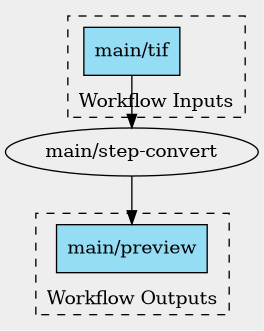

In [1]:
cwltool --print-dot $cwl_file 2> /dev/null | dot -Tpng | display

3. Provide Input Parameters

Create an input file `inputs.yml` with the GeoTIFF URL:

```yaml
tif: "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/TCI.tif"
```

4. Execute the Workflow

Run the workflow using `cwltool`:

```bash
cwltool return-output-file input.yml
```

In [1]:
echo 'tif: "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/TCI.tif"' > input.yml

cwltool $cwl_file input.yml > output.json

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/01-output/return-output-file.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/01-output/return-output-file.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step-convert
INFO [step step-convert] start
INFO [job step-convert] /tmp/_yadfuo1$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/_yadfuo1,target=/QiLhMt \
    --mount=type=bind,source=/tmp/f67w5sf6,target=/tmp \
    --workdir=/QiLhMt \
    --read-only=true \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/02qwnmr2/20241229131626-799588.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/QiLhMt \
    ghcr.io/eoap/how-to/how-to-container:1.1.0 \
    rio \
    convert \
    --driver \
    PNG \
    --dtype \
    uint8 \
    https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/10/T/FK/2021/7/S2B_10TFK_20210713_0_L2A/TCI.tif \
    preview.png
INFO [job step-convert] Max memory used: 1133MiB
INFO [job step-conver

## Expected Output

The `rio` tool processes the input GeoTIFF and generates a PNG file named `preview.png`.

The `outputs` block ensures:

* The file is located using `glob: preview.png`.
* It is made available as the workflow output.

Example Workflow Output:

In [ ]:
cat output.json | yq e . - 

The `preview.png` file is now accessible in the working directory or as defined by the CWL runner.



## Key Takeaways

* The `outputs` block defines how to capture and return files:

  * `type: File`: Specifies the output type.
  * `outputBinding.glob`: Matches the file name or pattern.
* Ensure the file name in glob matches the file name generated by the tool (preview.png).

By focusing on the `outputs` block, this guide highlights how to capture and return output files in CWL workflows.

In [ ]:
rm -f output.json
rm -f input.yml
rm -f preview.png